In [161]:
#https://github.com/zclaytor/kiauhoku/blob/master/notebooks/mcmc_offsets.ipynb
import numpy as np
import matplotlib.pyplot as plt
import kiauhoku as kh

In [162]:
# data/err are [teff, L/Lsun, [M/H]]
#data = [3410, 0.1020, -0.12] #au mic pre star lite
#err = [105, 0.0037, 0.11] #au mic pre star lite
data = [5374, 0.577, -0.02] #HD3167 pre star lite
err = [52, 0.02, 0.17] #HD3167 pre star lite


In [163]:
yrec = kh.load_interpolator('yrec')
mist = kh.load_interpolator('mist')
dart = kh.load_interpolator('dartmouth')
gars = kh.load_interpolator('garstec')

In [164]:
def yrec_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None

    model_teff = 10**model['Log Teff(K)']
    model_lum = 10**model['L/Lsun']
    model_met = np.log10(model['Zsurf']/model['Xsurf']/0.0253)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age(Gyr)']
    model['lnprob'] = chisq
    
    return chisq, model

def mist_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = 10**model['log_Teff']
    model_lum = 10**model['log_L']
    model_met = model['log_surf_z'] - np.log10(model['surface_h1']*0.0173)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['star_age'] / 1e9
    model['lnprob'] = chisq

    return chisq, model

def dart_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = 10**model['Log T']
    model_lum = 10**model['Log L']
    model_met = np.log10(model['(Z/X)_surf']/0.0229)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age (yrs)'] / 1e9
    model['lnprob'] = chisq

    return chisq, model

def gars_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = model['Teff']
    model_lum = 10**model['Log L/Lsun']
    model_met = np.log10(model['Zsurf']/model['Xsurf']/0.0245)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age(Myr)'] / 1e3
    model['lnprob'] = chisq

    return chisq, model


In [165]:


def mcmc(grid, lnprob, data, err):
    sampler, chains = grid.mcmc_star(
        lnprob,
        args=(data, err),
        initial_guess=(0.7, 0, 100),
        guess_width=(0.1, 0.1, 100),
        n_walkers=12,
        n_burnin=100,
        n_iter=1000
    )
    
    return sampler, chains

def compute_offsets(label, ref='yrec'):
    if ref == 'yrec':
        ref_val = yrec_chains[label].median()
    elif ref == 'mist':
        ref_val = mist_chains[label].median()
    elif ref == 'dart':
        ref_val = dart_chains[label].median()
    elif ref == 'gars':
        ref_val = gars_chains[label].median()

    offsets = {
        f'yrec-{ref}': yrec_chains[label].median() - ref_val,
        f'mist-{ref}': mist_chains[label].median() - ref_val,
        f'dart-{ref}': dart_chains[label].median() - ref_val,
        f'gars-{ref}': gars_chains[label].median() - ref_val
    }

    offsets.pop(f'{ref}-{ref}')
    return offsets



In [166]:
yrec_sampler, yrec_chains = mcmc(yrec, yrec_prob, data, err)
mist_sampler, mist_chains = mcmc(mist, mist_prob, data, err)
dart_sampler, dart_chains = mcmc(dart, dart_prob, data, err)
gars_sampler, gars_chains = mcmc(gars, gars_prob, data, err)


  0%|                                                                                               | 0/100 [00:00<?, ?it/s]/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: R

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: R

In [167]:
print(compute_offsets('age'))
print(compute_offsets('initial_mass'))

{'mist-yrec': 0.5731346532318051, 'dart-yrec': -0.5185752337015685, 'gars-yrec': -5.383371065231194}
{'mist-yrec': 0.00413689200214451, 'dart-yrec': 0.006320990118566017, 'gars-yrec': 0.0075995404919104725}


In [181]:
from corner import corner
#pip install corner

In [182]:
#agelimit=2 #AU MIC
agelimit=14 #hd3167

In [183]:
print(yrec_chains)
yrec_chains_young=yrec_chains.drop(yrec_chains[yrec_chains.age>agelimit].index)

       initial_mass  initial_met         eep   Age(Gyr)    L/Lsun    R/Rsun  \
0          0.900448    -0.007532  188.976869   0.039109 -0.237391 -0.065795   
1          0.916588     0.104771  186.140381   0.037507 -0.233608 -0.049765   
2          0.879150    -0.055560  306.453924   6.640245 -0.251323 -0.075482   
3          0.878702     0.145471  367.161118  11.360540 -0.226717 -0.052093   
4          0.870569    -0.035043  182.783051   0.038731 -0.291168 -0.068307   
...             ...          ...         ...        ...       ...       ...   
11995      0.780764    -0.120566  398.176549  20.370215 -0.242022 -0.057882   
11996      0.753093    -0.228989  405.024429  22.964747 -0.230451 -0.058127   
11997      0.867351     0.061284  364.915498  11.436710 -0.230774 -0.056927   
11998      0.939772     0.044130  193.752811   0.040257 -0.227444 -0.068569   
11999      0.886011     0.118432  357.355125   9.779193 -0.228689 -0.056434   

           logg  Log Teff(K)  mass_conv_core  mass_

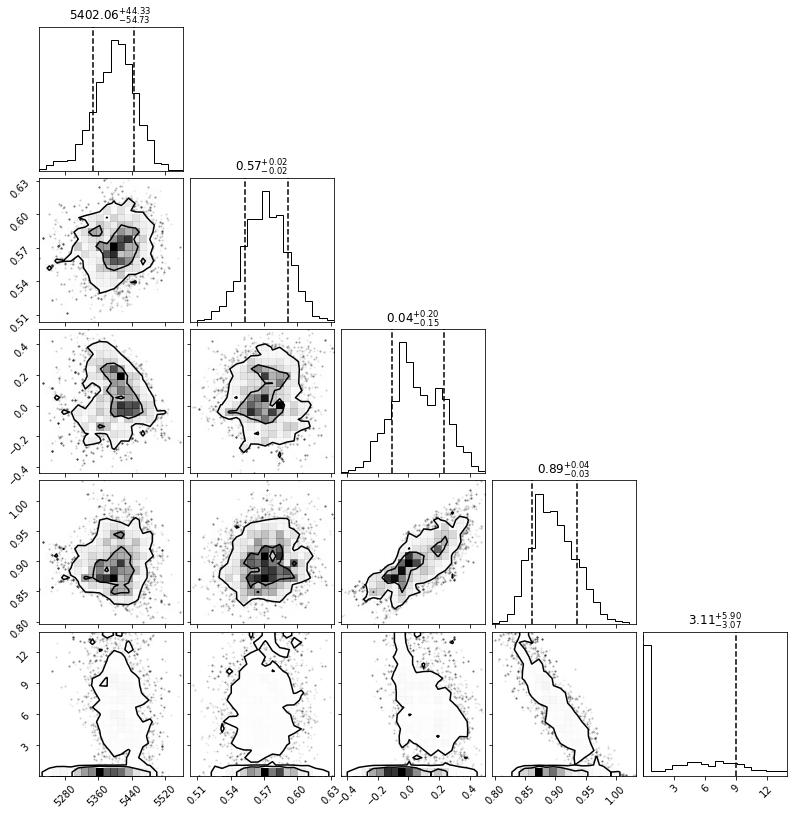

In [184]:
fig = corner(yrec_chains_young[['teff', 'luminosity', 'metallicity', 'Mass(Msun)', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('yrec_corner_prestarlite.png')

In [185]:
print (mist_chains)
mist_chains_young=mist_chains.drop(mist_chains[mist_chains.age>agelimit].index)

       initial_mass  initial_met         eep      star_age  star_mass  \
0          0.805194    -0.012919  405.124610  1.564691e+10   0.804948   
1          0.833578    -0.012475  386.246546  1.178250e+10   0.833381   
2          0.947674     0.197341  194.981050  4.074905e+07   0.947672   
3          0.712628    -0.275056  421.936983  2.365259e+10   0.712316   
4          0.977402     0.291936  311.223600  1.546008e+09   0.977370   
...             ...          ...         ...           ...        ...   
11995      0.878850    -0.057324  192.914148  3.599583e+07   0.878848   
11996      0.960928     0.142470  199.619570  4.780146e+07   0.960925   
11997      0.910410     0.013497  314.297336  1.915300e+09   0.910374   
11998      0.904743     0.191612  360.181479  7.424427e+09   0.904606   
11999      0.835466    -0.057040  375.031137  1.030130e+10   0.835292   

          star_mdot  he_core_mass  c_core_mass  o_core_mass     log_L  ...  \
0     -2.598250e-14           0.0          0.

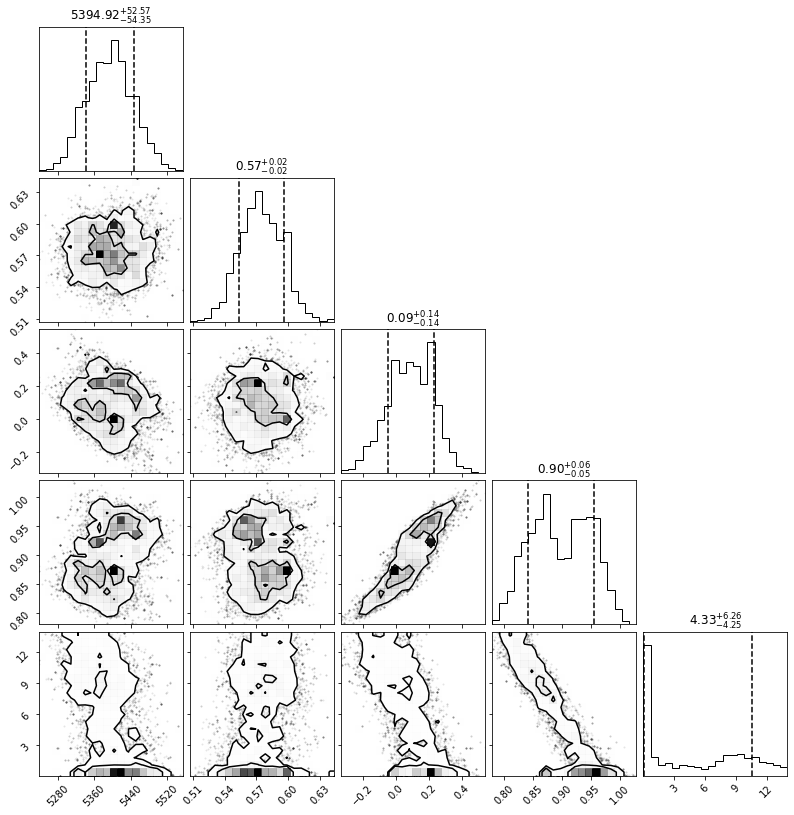

In [186]:
fig = corner(mist_chains_young[['teff', 'luminosity', 'metallicity', 'star_mass', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('mist_corner_prestarlite.png')

In [187]:
print(dart_chains)
dart_chains_young=dart_chains.drop(dart_chains[dart_chains.age>agelimit].index)

       initial_mass  initial_met         eep     Age (yrs)     Log T  \
0          0.903361     0.017121  191.788350  4.221572e+07  3.734620   
1          0.881750     0.047835  349.055917  8.286820e+09  3.728503   
2          0.875243    -0.156100  181.989536  3.495866e+07  3.731847   
3          0.895336     0.051350  326.194824  6.684266e+09  3.730536   
4          0.858859    -0.209534  179.102159  3.406291e+07  3.729480   
...             ...          ...         ...           ...       ...   
11995      0.907766     0.213282  346.140371  7.169749e+09  3.726110   
11996      0.923223     0.274321  353.823426  7.078271e+09  3.727367   
11997      0.853230    -0.037735  363.559056  1.010381e+10  3.728111   
11998      0.930806     0.242457  305.847784  4.727078e+09  3.727713   
11999      0.923222     0.126889  287.319232  4.214805e+09  3.730964   

          Log g     Log L     Log R    Y_core    Z_core  ...       L_H  L_He  \
0      4.534106 -0.248461 -0.070211  0.276138  0.019991

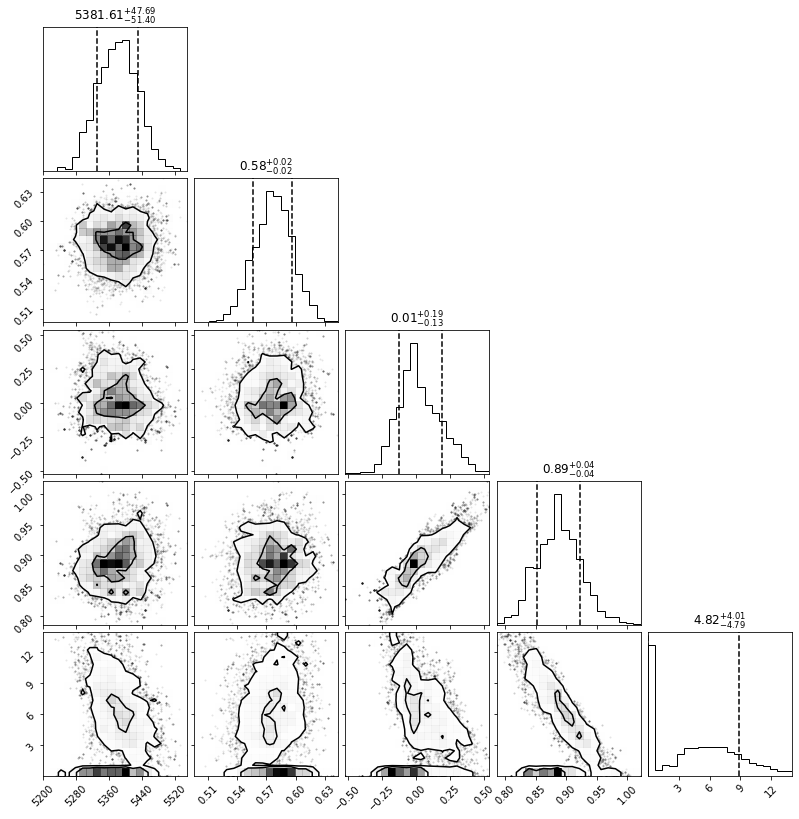

In [188]:
fig = corner(dart_chains_young[['teff', 'luminosity', 'metallicity', 'initial_mass',  'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('dart_corner_prestarlite.png')

In [189]:
gars_chains_nonan=(gars_chains.dropna())
#t=[np.NaN,np.NaN, np.NaN, 1]

gars_chains_nonanyoung=gars_chains_nonan.drop(gars_chains_nonan[gars_chains_nonan.age>agelimit].index)

In [190]:
print(gars_chains_nonanyoung)

       initial_mass  initial_met         eep     Age(Myr)    M/Msun  \
0          0.892083     0.151610  337.713281  7325.315045  0.891861   
1          0.854198    -0.272712  165.420917    35.598656  0.854198   
2          0.840576    -0.232206  154.818751    36.198352  0.840576   
3          0.871039    -0.273480  117.973488    29.526180  0.871039   
4          0.892189    -0.126262  138.412310    32.447141  0.892189   
...             ...          ...         ...          ...       ...   
11995      0.904381     0.159927  338.186152  6966.452547  0.904156   
11996      0.949499     0.428846  320.171030  5238.790035  0.949332   
11997      0.913478     0.098726  298.153575  4917.932523  0.913314   
11998      0.889585    -0.065474  172.477280    38.375432  0.889585   
11999      0.815889    -0.455713  140.098140    31.010390  0.815889   

              Teff  Log L/Lsun    R/Rsun      logg     Xsurf     Zsurf  \
0      5304.302579   -0.270310  0.870583  4.508731  0.713891  0.027738   

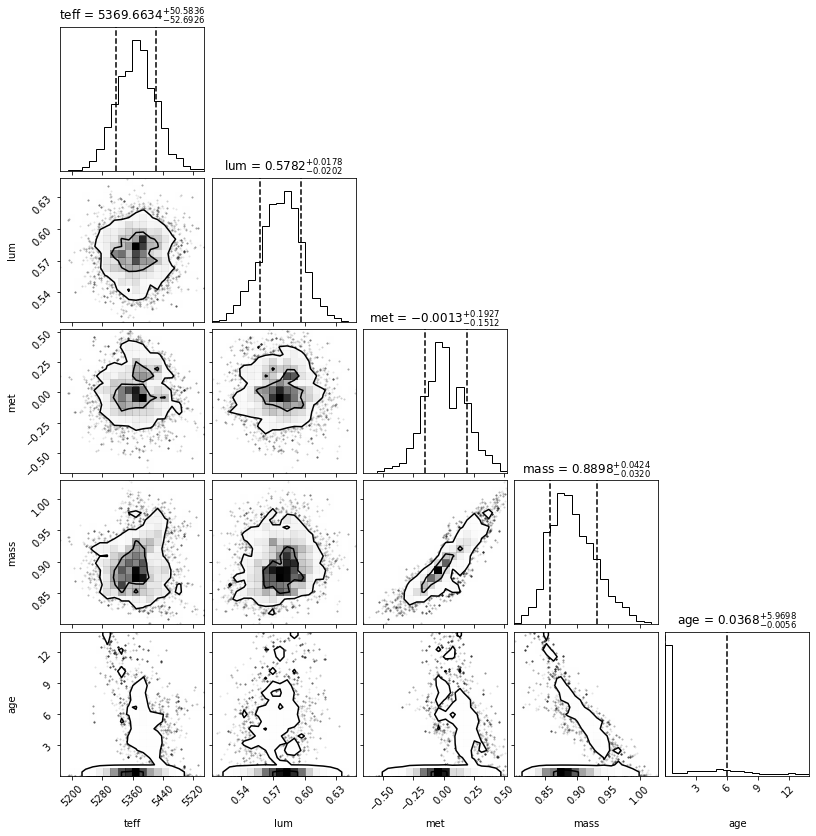

In [191]:

fig = corner(gars_chains_nonanyoung[['teff', 'luminosity', 'metallicity', 'M/Msun', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)), title_fmt='.4f',
             labels=['teff', 'lum', 'met', 'mass', 'age' ])
#axes = np.array(fig.axes).reshape((5, 5))
#ax = axes[0, 3]
#ax.set_xlim([0,1])
fig.savefig('gars_corner_prestarlite.png')


In [192]:
#from corner import quantile

In [193]:
#print(quantile(gars_chains_nonan[['teff', 'luminosity', 'metallicity', 'M/Msun', 'age']]))